In [1]:
from pathlib import Path

# Get the current working directory as a Path object
current_path = Path.cwd()
home_folder = 'evan_home'

# Traverse up the directory tree until you find the target folder
for parent in [current_path] + list(current_path.parents):
    if parent.name == home_folder:
        home_path = parent
        break
else:
    raise ValueError(f"Folder '{home_folder}' not found in the current working directory.")

print("Home Path:", home_path)
source_code_dir = home_path / 'Source_code'
dataset_dir = home_path / 'Dataset'


Home Path: c:\Users\evanlee\Documents\Bmi_NAS_evan\evan_home


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import scipy
import sklearn
import copy
import importlib


In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score, auc, precision_recall_curve, average_precision_score
from sklearn.model_selection import cross_val_score, cross_validate, KFold
from sklearn.metrics import make_scorer, matthews_corrcoef


In [4]:
import scanpy as sc

# adata = sc.read_h5ad(r"C:\Users\evanlee\Documents\Research_datasets\PBMC_Hao\GSE164378_Hao\Harmony_noZ\Hao_Harmony_test_no_scale.h5ad")
adata = sc.read_h5ad(dataset_dir / 'PBMC_Hao/GSE164378_Hao/Harmony_noZ/Hao_Harmony_test_no_scale.h5ad')
print('Original adata:', adata.shape)
adata.obs['celltype.l2'] = adata.obs['celltype.l2'].str.replace(' ', '_')
label = adata.obs['celltype.l2'].tolist()
types = np.unique(label).tolist()
print('all cell types:', types)
print('====================')
# del adata


Original adata: (161764, 33538)
all cell types: ['ASDC', 'B_intermediate', 'B_memory', 'B_naive', 'CD14_Mono', 'CD16_Mono', 'CD4_CTL', 'CD4_Naive', 'CD4_Proliferating', 'CD4_TCM', 'CD4_TEM', 'CD8_Naive', 'CD8_Proliferating', 'CD8_TCM', 'CD8_TEM', 'Doublet', 'Eryth', 'HSPC', 'ILC', 'MAIT', 'NK', 'NK_CD56bright', 'NK_Proliferating', 'Plasmablast', 'Platelet', 'Treg', 'cDC1', 'cDC2', 'dnT', 'gdT', 'pDC']


In [5]:
adata.obs.head()

,celltype.l1,celltype.l2,celltype.l3,Batch,donor,time,lane,Phase,nCount_ADT,nFeature_ADT,nCount_RNA,nFeature_RNA,leiden
L1_AAACCCAAGAAACTCA,Mono,CD14_Mono,CD14 Mono,Batch1,P2,7,L1,G1,7535,217,10823,2915,4
L1_AAACCCAAGACATACA,CD4 T,CD4_TCM,CD4 TCM_1,Batch1,P1,7,L1,G1,6013,209,5864,1617,2
L1_AAACCCACAACTGGTT,CD8 T,CD8_Naive,CD8 Naive,Batch1,P4,2,L1,S,6620,213,5067,1381,5
L1_AAACCCACACGTACTA,NK,NK,NK_2,Batch1,P3,7,L1,G1,3567,202,4786,1890,3
L1_AAACCCACAGCATACT,CD8 T,CD8_Naive,CD8 Naive,Batch1,P4,7,L1,G1,6402,215,6505,1621,5


## Read features

In [6]:
import os
os.chdir(r"C:\Users\evanlee\Documents\GitHub\EvanPys\Progress\PBMC_Hao_batch_noZ\Level2\feature_selection_k3")
os.chdir(source_code_dir / 'PBMC_Hao_batch_noZ/Level2/feature_selection_k3')

features_dict = {}
# Read features for each celltype
for celltype in types:
    try:
        feature_df = pd.read_csv(f'{celltype}_features.txt', names=['Gene', 'Weight', 'Tendency'], sep='\t')
        features_dict[celltype] = feature_df
    except:
        print('skipping:', celltype)
        continue

In [7]:
features_dict.keys()

dict_keys(['ASDC', 'B_intermediate', 'B_memory', 'B_naive', 'CD14_Mono', 'CD16_Mono', 'CD4_CTL', 'CD4_Naive', 'CD4_Proliferating', 'CD4_TCM', 'CD4_TEM', 'CD8_Naive', 'CD8_Proliferating', 'CD8_TCM', 'CD8_TEM', 'Doublet', 'Eryth', 'HSPC', 'ILC', 'MAIT', 'NK', 'NK_CD56bright', 'NK_Proliferating', 'Plasmablast', 'Platelet', 'Treg', 'cDC1', 'cDC2', 'dnT', 'gdT', 'pDC'])

In [8]:
count_df = pd.DataFrame(columns=['Feature_count', 'Positive_feature_count'])
for celltype in features_dict.keys():
    feature_df = features_dict[celltype]
    feature_count = feature_df.shape[0]
    positive_count = feature_df[feature_df['Tendency'] == 1].shape[0]
    count_df.loc[celltype] = [feature_count, positive_count]
count_df

,Feature_count,Positive_feature_count
ASDC,47,25
B_intermediate,96,49
B_memory,170,90
B_naive,9,6
CD14_Mono,29,16
CD16_Mono,37,17
CD4_CTL,122,45
CD4_Naive,730,393
CD4_Proliferating,70,35
CD4_TCM,247,133


## Build classifiers (K-fold CV)

In [8]:
import pickle

def LR_kfold(data, all_features_dict, celltype, k=5):
    # subset data to celltype features
    X = data[:, all_features_dict[celltype]['Gene'].tolist()].X
    # Binary label
    y = [1 if i==celltype else 0 for i in data.obs['celltype.l2'].tolist()]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

    clf = LogisticRegression(penalty='l2', solver='lbfgs', C=1.0, max_iter=1000)
    clf.fit(X_train, y_train)

    # Kfold cross validation
    scoring = {
        'accuracy': 'accuracy',
        'precision': 'precision',
        'recall': 'recall',
        'f1_score': 'f1',
        'roc_auc': 'roc_auc',
        'average_precision': 'average_precision',  # PR AUC
        'mcc': make_scorer(matthews_corrcoef)
    }
    cv_results = cross_validate(clf, X, y, cv=5, scoring=scoring, n_jobs=32)

    mean_accuracy = np.mean(cv_results['test_accuracy'])
    mean_precision = np.mean(cv_results['test_precision'])
    mean_recall = np.mean(cv_results['test_recall'])
    mean_f1 = np.mean(cv_results['test_f1_score'])
    mean_auc = np.mean(cv_results['test_roc_auc'])
    mean_pr_auc = np.mean(cv_results['test_average_precision'])
    mean_mcc = np.mean(cv_results['test_mcc'])
    mean_metrics = [mean_accuracy, mean_precision, mean_recall, mean_f1, mean_auc, mean_pr_auc, mean_mcc]

    return clf, mean_metrics

In [ ]:
cols = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC-AUC', 'PR-AUC', 'MCC']
all_metrics = pd.DataFrame(columns=cols)
for celltype in types:
    print('====================')
    print('K-fold CV for:', celltype)
    clf, metrics = LR_kfold(adata, features_dict, celltype, k=5)  # metrics is a list
    print(metrics)
    
    # Append metrics to all_metrics
    all_metrics.loc[celltype] = metrics

    # output LR model as pickle
    # filename = f'LR_{celltype}_Harmony_l1.pkl'
    # with open(filename, 'wb') as f:
    #     pickle.dump(clf, f)


K-fold CV for: ASDC
[0.99993818116626, 0.9733333333333334, 0.8933333333333333, 0.9287709991158268, 0.9999835074074903, 0.9739315080344493, 0.9310108782849277]
K-fold CV for: B_intermediate
[0.9947083371434605, 0.8509147146429659, 0.7906068057562468, 0.8172035016019779, 0.9976164167313414, 0.9003000382942412, 0.8163462229160074]
K-fold CV for: B_memory
[0.9974963529020542, 0.943281271170464, 0.9333333333333333, 0.9378166744954974, 0.9993145961727722, 0.9842008916167428, 0.9367946065248158]
K-fold CV for: B_naive
[0.9955305254921119, 0.9534820414317429, 0.953095796157811, 0.9531389502837166, 0.9993741548836358, 0.986596032273247, 0.9508751244535976]
K-fold CV for: CD14_Mono
[0.9908570479156993, 0.9788228620537207, 0.9867416256734598, 0.9827471167729389, 0.998859436488498, 0.9947628135757848, 0.9765603320147666]
K-fold CV for: CD16_Mono
[0.9945290718120825, 0.9289097826370856, 0.9319620253164557, 0.9302543040392821, 0.9991841221054031, 0.9789103603830153, 0.9275057860180583]
K-fold CV for

In [10]:
all_metrics

,Accuracy,Precision,Recall,F1-score,ROC-AUC,PR-AUC,MCC
ASDC,0.999938,0.973333,0.893333,0.928771,0.999984,0.973932,0.931011
B_intermediate,0.994708,0.850915,0.790607,0.817204,0.997616,0.900300,0.816346
B_memory,0.997496,0.943281,0.933333,0.937817,0.999315,0.984201,0.936795
B_naive,0.995531,0.953482,0.953096,0.953139,0.999374,0.986596,0.950875
CD14_Mono,0.990857,0.978823,0.986742,0.982747,0.998859,0.994763,0.976560
CD16_Mono,0.994529,0.928910,0.931962,0.930254,0.999184,0.978910,0.927506
CD4_CTL,0.996612,0.873180,0.803601,0.835452,0.997785,0.916963,0.835240
CD4_Naive,0.984644,0.924800,0.935980,0.929928,0.997021,0.977222,0.921600
CD4_Proliferating,0.999740,0.825041,0.788312,0.801034,0.999864,0.876409,0.803715
CD4_TCM,0.966488,0.831341,0.806702,0.816372,0.988958,0.896484,0.799557


In [ ]:
os.chdir(r"C:\Users\evanlee\Documents\GitHub\EvanPys\Progress\PBMC_Hao_batch_noZ\Level2\LR_likelihood")
os.chdir(source_code_dir / 'PBMC_Hao_batch_noZ/Level2/LR_likelihood')
# save metrics
all_metrics.index = types
all_metrics.to_csv('LR_metrics_L2_k3.csv')

## Plot classifier K-fold CV metrics

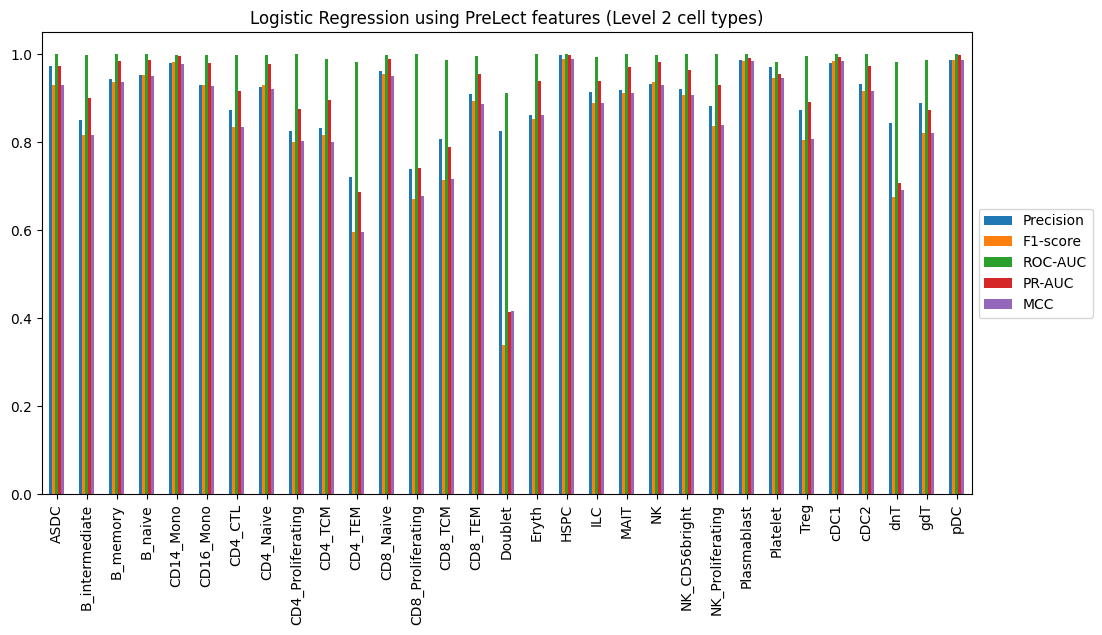

In [12]:
cols = ['Precision', 'F1-score', 'ROC-AUC', 'PR-AUC', 'MCC']

# Plot metrics for each celltype
ax = all_metrics[cols].plot.bar(rot=90, figsize=(12,6), title='Logistic Regression using PreLect features (Level 2 cell types)')
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

## Get likelihood from LR model

In [13]:
def LR_likelihood_pred_prob(data, all_features_dict, celltype):
    print('====================')
    print('Celltype:', celltype)
    # subset data to celltype features
    X = data[:, all_features_dict[celltype]['Gene'].tolist()].X
    # Binary label
    y = [1 if i==celltype else 0 for i in data.obs['celltype.l2'].tolist()]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

    clf = LogisticRegression(penalty='l2', solver='lbfgs', C=1.0, max_iter=1000, n_jobs=32)
    clf.fit(X_train, y_train)

    # likelihood of the positive class for each observation
    likelihood = clf.predict_proba(X)[:, 1]  # >0.5: predict celltype, <0.5: predict not celltype
    print('likelihood > 0.5:', sum(likelihood > 0.5))  # decision_scores > 0 的有幾個

    return likelihood


In [14]:
celltype = 'ASDC'
B_likelihood = LR_likelihood_pred_prob(adata, features_dict, celltype)
B_likelihood.shape

Celltype: ASDC
likelihood > 0.5: 72


(161764,)

In [15]:
B_likelihood[:5]

array([5.72281753e-06, 6.24579644e-09, 1.11069766e-08, 3.96501131e-08,
       1.11461741e-09])

In [16]:
likelihood_dict = {}
for celltype in types:
    likelihood_dict[celltype] = LR_likelihood_pred_prob(adata, features_dict, celltype)

Celltype: ASDC
likelihood > 0.5: 72
Celltype: B_intermediate
likelihood > 0.5: 2255
Celltype: B_memory
likelihood > 0.5: 3265
Celltype: B_naive
likelihood > 0.5: 7745
Celltype: CD14_Mono
likelihood > 0.5: 43055
Celltype: CD16_Mono
likelihood > 0.5: 6327
Celltype: CD4_CTL
likelihood > 0.5: 1603
Celltype: CD4_Naive
likelihood > 0.5: 17669
Celltype: CD4_Proliferating
likelihood > 0.5: 115
Celltype: CD4_TCM
likelihood > 0.5: 14460
Celltype: CD4_TEM
likelihood > 0.5: 3041
Celltype: CD8_Naive
likelihood > 0.5: 10582
Celltype: CD8_Proliferating
likelihood > 0.5: 77
Celltype: CD8_TCM
likelihood > 0.5: 2284
Celltype: CD8_TEM
likelihood > 0.5: 11411
Celltype: Doublet
likelihood > 0.5: 149
Celltype: Eryth
likelihood > 0.5: 91
Celltype: HSPC
likelihood > 0.5: 324
Celltype: ILC
likelihood > 0.5: 131
Celltype: MAIT
likelihood > 0.5: 2762
Celltype: NK
likelihood > 0.5: 17376
Celltype: NK_CD56bright
likelihood > 0.5: 923
Celltype: NK_Proliferating
likelihood > 0.5: 492
Celltype: Plasmablast
likelihood

In [17]:
# turn likelihood_dict into dataframe
likelihood_df = pd.DataFrame(likelihood_dict)
likelihood_df.head()

,ASDC,B_intermediate,B_memory,B_naive,CD14_Mono,CD16_Mono,CD4_CTL,CD4_Naive,CD4_Proliferating,CD4_TCM,...,NK_CD56bright,NK_Proliferating,Plasmablast,Platelet,Treg,cDC1,cDC2,dnT,gdT,pDC
0,5.722818e-06,0.000007,3.393092e-07,0.000006,9.777453e-01,2.108377e-04,6.052868e-08,8.579319e-08,5.284719e-06,0.000107,...,2.419641e-09,2.057269e-07,9.855337e-09,0.000659,1.488459e-07,7.928539e-08,8.384308e-05,0.000009,0.000002,1.412971e-07
1,6.245796e-09,0.000027,5.821373e-06,0.000019,5.526651e-06,4.341174e-07,1.813782e-06,7.185685e-05,3.353702e-05,0.938144,...,9.514264e-06,2.463243e-07,9.798958e-07,0.000315,4.732758e-04,5.509419e-07,7.612749e-09,0.000148,0.000813,3.155219e-07
2,1.110698e-08,0.000023,1.361200e-06,0.000007,2.078846e-07,1.397198e-07,6.916468e-06,1.511008e-04,1.848008e-06,0.000271,...,7.635713e-06,9.198068e-08,8.556489e-07,0.000247,1.171527e-02,3.617054e-06,3.587770e-08,0.000243,0.004095,6.870338e-07
3,3.965011e-08,0.000067,2.269681e-10,0.000006,1.976529e-06,9.098764e-07,1.427149e-06,3.557825e-07,1.388949e-10,0.000001,...,1.674584e-07,1.095280e-04,2.692548e-07,0.000310,2.196458e-07,7.052609e-07,5.625754e-09,0.000003,0.021700,3.712620e-05
4,1.114617e-09,0.000022,1.374374e-05,0.000001,2.354446e-08,8.261386e-07,2.798818e-07,3.723426e-05,4.089854e-07,0.000072,...,4.260595e-06,6.287517e-07,1.957964e-06,0.000317,2.919631e-04,5.663801e-07,2.089452e-08,0.001021,0.002565,4.706639e-07


In [18]:
likelihood_df.shape

(161764, 31)

In [19]:
# row sum
likelihood_df.sum(axis=1)


0         0.980143
1         0.954467
2         1.061808
3         1.021348
4         1.104038
            ...   
161759    1.100644
161760    1.006940
161761    1.210880
161762    0.973662
161763    0.983071
Length: 161764, dtype: float64

In [ ]:
os.chdir(r"C:\Users\evanlee\Documents\GitHub\EvanPys\Progress\PBMC_Hao_batch_noZ\Level2\LR_likelihood")
os.chdir(source_code_dir / 'PBMC_Hao_batch_noZ/Level2/LR_likelihood')
likelihood_df.to_csv('L2_likelihood_df_k3.csv')

## Assign the celltype with the largest likelihood (no odds ratio)

In [21]:
largest_values = []
largest_columns = []
assignments = []
for index, row in likelihood_df.iterrows():
    # find largest value and their corresponding columns
    largest_value = row.max()
    largest_column = row.idxmax()
    largest_values.append(largest_value)
    largest_columns.append(largest_column)

    assign = largest_column
    assignments.append(assign)

result_df = pd.DataFrame({'Largest Value': largest_values, 'Largest Column': largest_columns, 'Assignment': assignments})
result_df.shape


(161764, 3)

In [22]:
result_df.head(20)

,Largest Value,Largest Column,Assignment
0,0.977745,CD14_Mono,CD14_Mono
1,0.938144,CD4_TCM,CD4_TCM
2,0.999757,CD8_Naive,CD8_Naive
3,0.998044,NK,NK
4,0.999894,CD8_Naive,CD8_Naive
5,0.960520,CD8_TEM,CD8_TEM
6,0.539546,CD14_Mono,CD14_Mono
7,0.999393,B_intermediate,B_intermediate
8,0.999921,NK,NK
9,0.999881,CD8_Naive,CD8_Naive


## Confusion heatmap

In [23]:
import pandas as pd

# Get the true labels
true_labels = adata.obs['celltype.l2'].tolist()

# Get the predicted labels
predicted_labels = result_df['Assignment'].tolist()

# Create the confusion matrix
cm = pd.crosstab(true_labels, predicted_labels, rownames=['True'], colnames=['Predicted'], margins=False)

# reorder columns
# cm = cm.reindex(types + ['Uncertain'], axis=1)

# replace NaN with 0
cm = cm.fillna(0)
cm = cm.astype(int)


In [24]:
cm

Predicted,ASDC,B_intermediate,B_memory,B_naive,CD14_Mono,CD16_Mono,CD4_CTL,CD4_Naive,CD4_Proliferating,CD4_TCM,...,NK_CD56bright,NK_Proliferating,Plasmablast,Platelet,Treg,cDC1,cDC2,dnT,gdT,pDC
True,,,,,,,,,,,,,,,,,,,,,
ASDC,62,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,9,0,0,5
B_intermediate,0,2027,112,279,2,0,0,0,0,3,...,0,0,0,0,1,0,0,1,0,0
B_memory,0,107,3159,10,1,1,0,0,0,1,...,1,0,2,0,0,0,0,0,1,0
B_naive,0,118,55,7529,2,2,0,1,0,1,...,1,0,0,0,1,0,0,0,1,0
CD14_Mono,0,0,1,0,42376,230,0,2,0,4,...,0,0,2,10,2,0,45,0,0,0
CD16_Mono,0,0,0,0,324,5981,0,0,0,0,...,0,0,0,0,0,0,4,0,0,0
CD4_CTL,0,0,0,0,0,0,1624,0,0,8,...,0,0,0,1,0,0,0,0,3,0
CD4_Naive,0,0,0,0,0,0,0,17056,0,308,...,0,0,0,0,74,0,0,4,6,0
CD4_Proliferating,0,0,0,0,2,0,0,0,95,4,...,0,4,0,0,0,0,0,0,0,0


In [25]:
cm.to_csv('likelihood_assignment_confusion_matrix_k3.csv')

## Plot confusion matrix

In [3]:
import os
os.chdir('./LR_likelihood')
cm = pd.read_csv('likelihood_assignment_confusion_matrix_k3.csv', index_col=0)

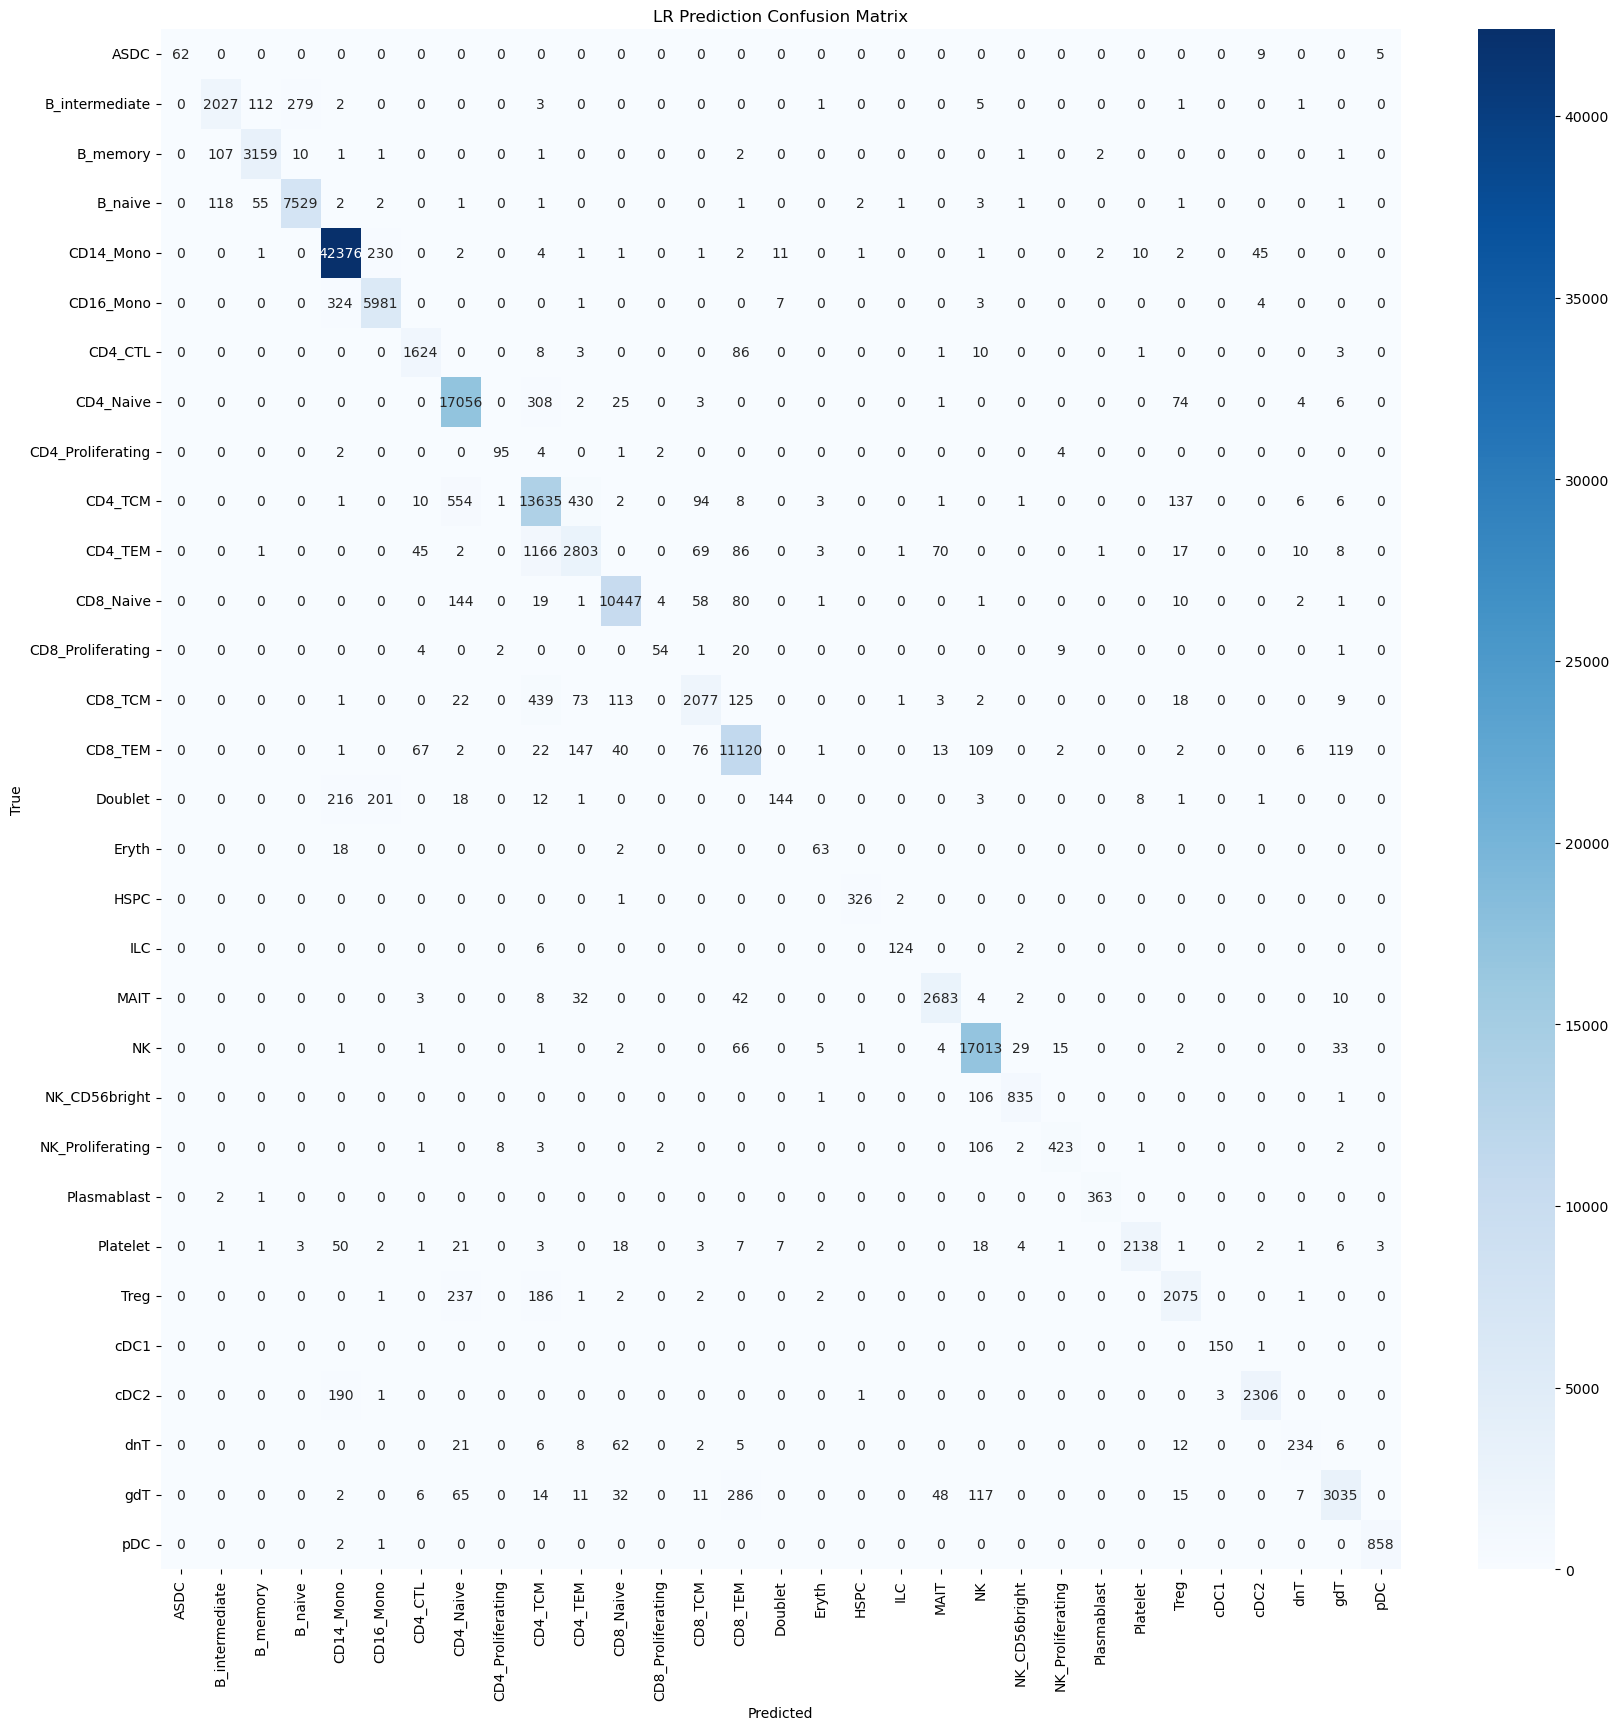

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20,20))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('LR Prediction Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [6]:
row_sum = cm.sum(axis=1)
row_sum


True
ASDC                    76
B_intermediate        2431
B_memory              3285
B_naive               7718
CD14_Mono            42690
CD16_Mono             6320
CD4_CTL               1736
CD4_Naive            17479
CD4_Proliferating      108
CD4_TCM              14889
CD4_TEM               4282
CD8_Naive            10768
CD8_Proliferating       91
CD8_TCM               2883
CD8_TEM              11727
Doublet                605
Eryth                   83
HSPC                   329
ILC                    132
MAIT                  2784
NK                   17173
NK_CD56bright          943
NK_Proliferating       548
Plasmablast            366
Platelet              2293
Treg                  2507
cDC1                   151
cDC2                  2501
dnT                    356
gdT                   3649
pDC                    861
dtype: int64

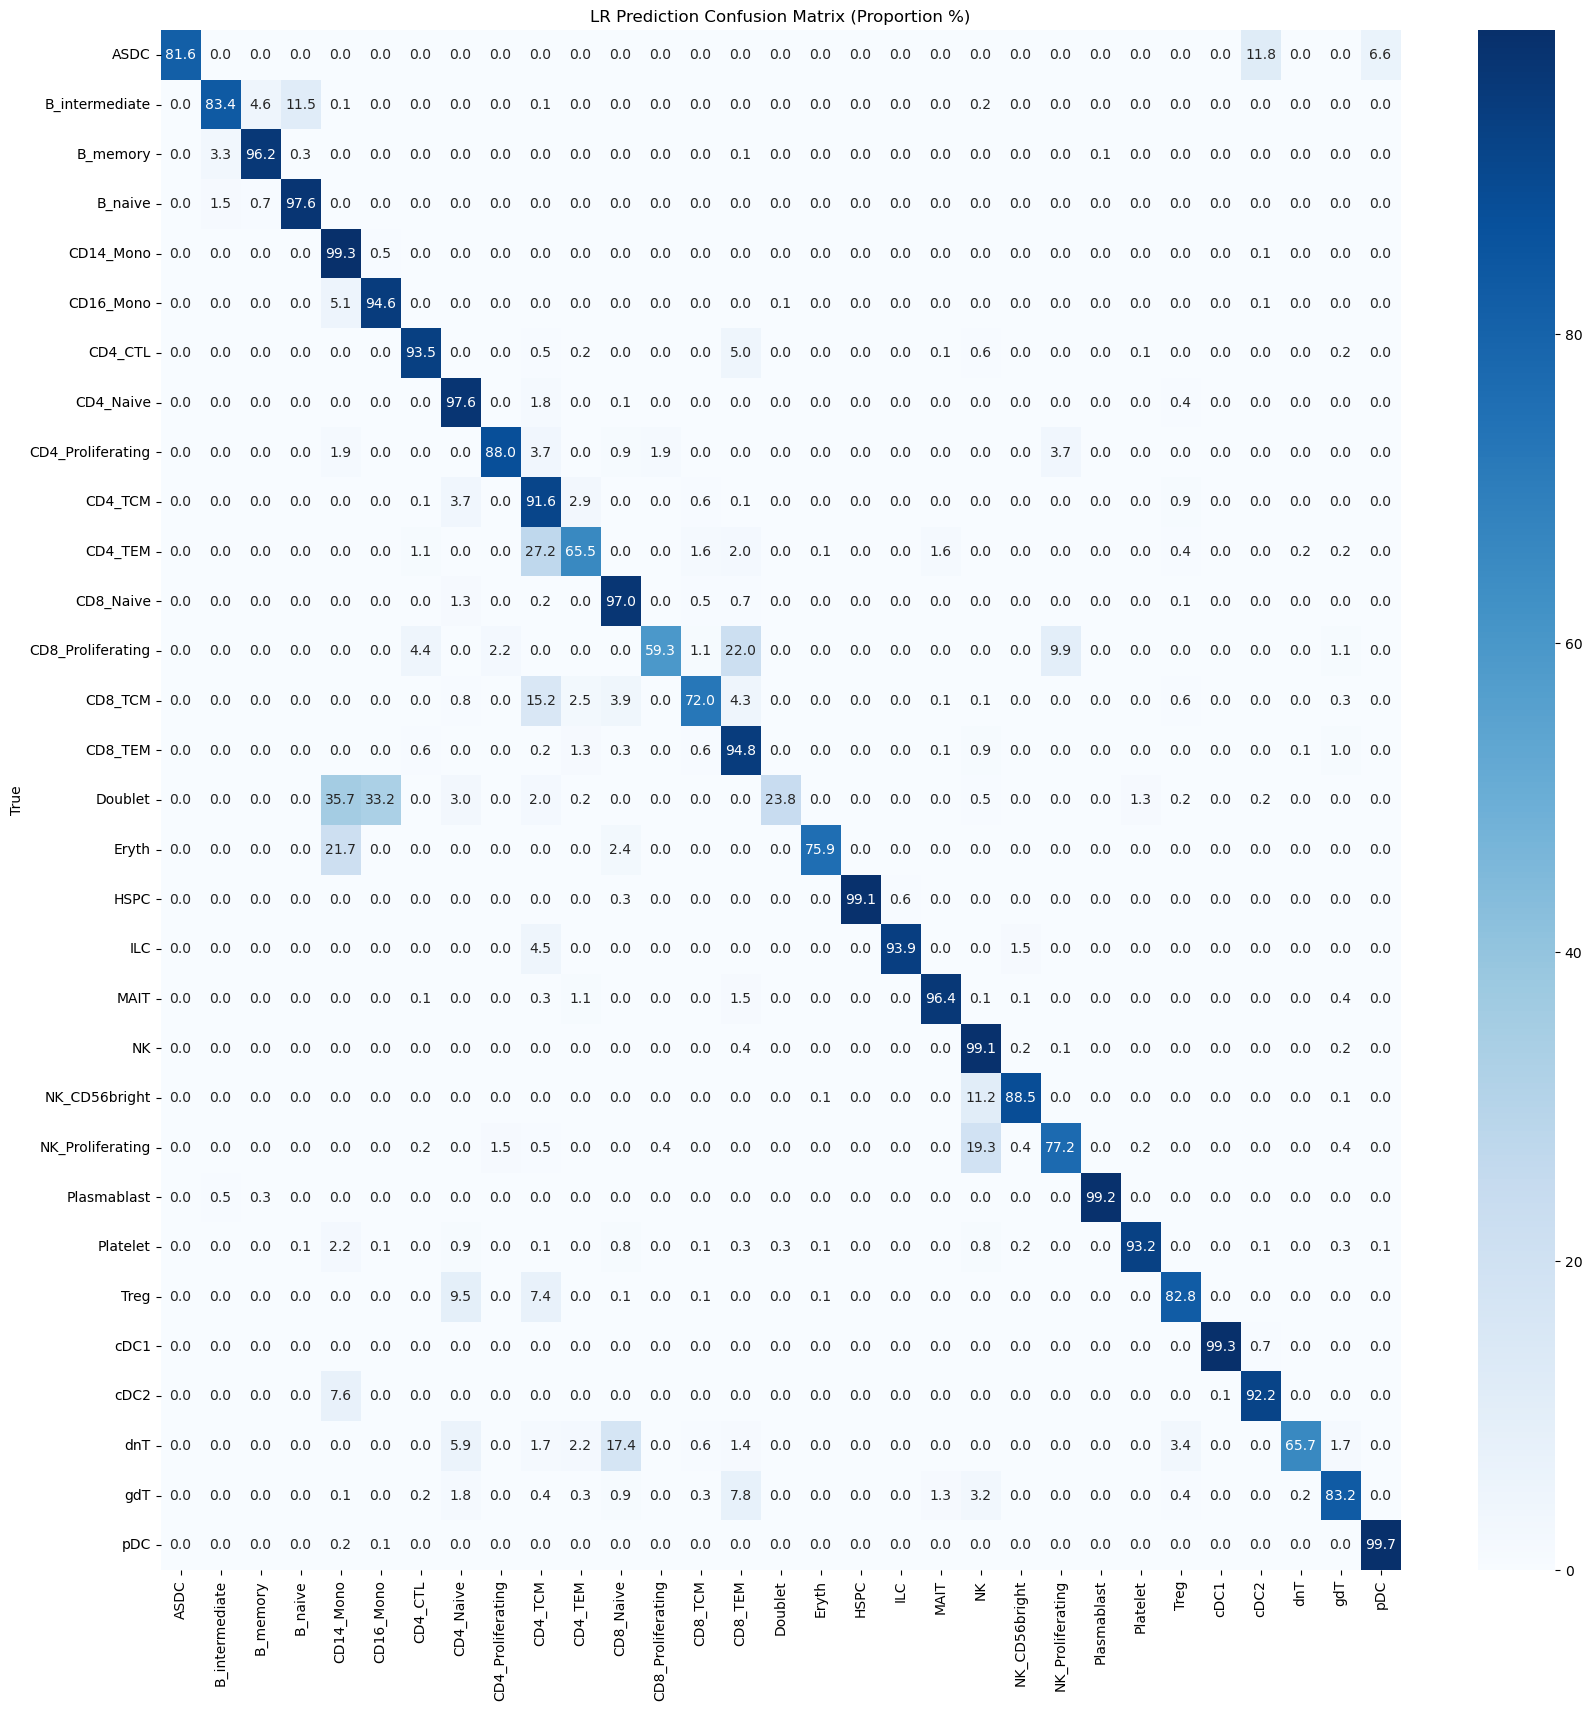

In [7]:
cm_proportion = cm.div(row_sum, axis=0)
cm_proportion *= 100
plt.figure(figsize=(20,20))
sns.heatmap(cm_proportion, fmt=".1f", annot=True, cmap='Blues')
plt.title('LR Prediction Confusion Matrix (Proportion %)')
plt.savefig('cm_plot.png', dpi=300)
plt.show()

## Calculate accuracy

In [8]:
accuracy = sum(np.diag(cm)) / cm.values.sum()
accuracy

0.9446786676887318

In [9]:
cm.values.sum()

161764